# Ayudantía 8

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import time

### Algo de código para FD2D

¿Qué hacemos si no tenemos condición de borde 0?

In [2]:
def FD2D_System(f, uD, N=50):
    """
    Dominio (abierto) de NxN puntos
    """
    h = 1./(N+1)
    M = int(N*N)
    A = np.zeros((M, M), dtype=float)
    b = np.zeros((N, N), dtype=float)
    
    for i in range(M):
        A[i, i] = 4
        if i < M-1 and (i+1)%N!=0:
            A[i, i+1] = -1
        if i > 0 and i%N!=0:
            A[i, i-1] = -1 
        if i + N < M:
            A[i, i+N] = -1
        if i - N >= 0:
            A[i, i-N] = -1
        
    # Hasta acá lo mismo de siempre.
    # Armamos el lado derecho
    for i in range(N):
        xi = (i+1)*h
        for j in range(N):
            yj = (j+1)*h
            b[i, j] += (h**2)*f([xi, yj])
            if j == 0:
                b[i, j] += uD([xi, 0])
            elif j == N-1:
                b[i, j] += uD([xi, 1])
            
            if i == 0:
                b[i, j] += uD([0, yj])
            elif i == N-1:
                b[i, j] += uD([1, yj])
    
    b = b.reshape(M)
    FreeNodes = np.array([i+k*(N+2) for k in range(1, N+1) for i in range(1, N+1)])
    
    return A, b, FreeNodes


def Fill_Boundary_Cond(uAprox, uD, FreeNodes, N):
    
    uh = uAprox.copy()
    M = uh.shape[0]
    h = 1/(N+1)
    BoundNodes = np.setdiff1d(np.arange(M), FreeNodes)
    uh = uh.reshape((N+2, N+2))
    
    for i in range(N+2):
        xi = i*h
        for j in range(N+2):
            yj = j*h
            if i + j*(N+2) in BoundNodes:
                uh[i, j] += uD([xi, yj])
    return uh

In [3]:
def Solve_System(f, uD, N=50):
    
    A, b, FreeNodes = FD2D_System(f, uD, N=N)
    uAprox = np.zeros((N+2)*(N+2), dtype=float)
    
    # Llenamos los nodos interiores (a los que resolvemos)
    uAprox[FreeNodes] = np.linalg.solve(A, b)
    
    #Llenamos los nodos exteriores (condicion de borde Dirichlet)
    uAprox = Fill_Boundary_Cond(uAprox, uD, FreeNodes, N=N)
    
    return uAprox

In [4]:
f = lambda x: np.sin(np.pi*x[0])*np.sin(np.pi*x[1])
uD = lambda x: 1
sol = lambda x:(1/(2*np.pi**2))*np.sin(np.pi*x[0])*np.sin(np.pi*x[1]) + 1

In [5]:
N = 40
uAprox = Solve_System(f, uD, N=N)

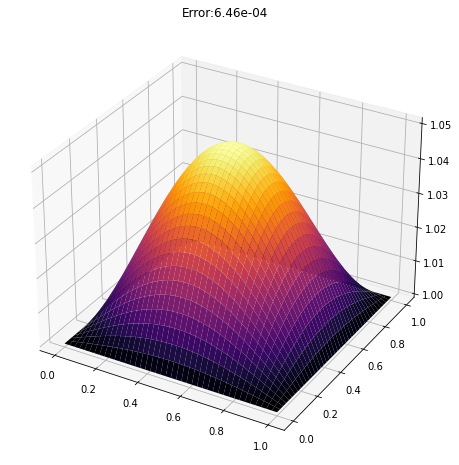

In [6]:
t = np.linspace(0, 1, num=N+2)
X, Y = np.meshgrid(t, t)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y, uAprox, cmap="inferno")
ax.set_title(f"Error:{np.linalg.norm(uAprox-sol([X, Y]), ord=np.inf):.2e}")
plt.show()

### SOR Simétrico (SSOR)

Hacemos '2' pasos de SOR, uno con forward subs, y otro con backward subs.

In [26]:
def decompose(A):
    """
    If A = D-E-F, 
    return matrices D, E, F
    """
    m, n = A.shape
    E, F = np.zeros_like(A), np.zeros_like(A)
    D = np.diag(A.diagonal())
    for i in range(m):
        for j in range(i):
            E[i, j] = -A[i, j]
        for j in range(i+1, n):
            F[i, j] = -A[i, j]
    return D, E, F

def RadioEspectral(A):
    eigvals = np.linalg.eigvals(A)
    return max(abs(eigvals))

def omega_opt_SOR(A):
    D, E, F = decompose(A)
    BJ = np.linalg.inv(D)@(E + F) #Matriz iteracion Jacobi
    rJ = RadioEspectral(BJ)
    return 2./(1. + np.sqrt(1. - rJ**2))

def SSOR(A, b, w=None, x0=None, tol=1e-14):
    """
    Symmetric SOR iteration to solve system Ax=b
    Starts at x0 = 0.
    Ends when |Ax-b| < tol.
    """
    m, n = A.shape
    D, E, F = decompose(A)
    
    #Parametro omega
    if w is None:
        w = omega_opt_SOR(A)
    
    # SOR iteration matrix and vector
    #Paso SOR original
    B1 = np.linalg.inv(D-w*E)@((1-w)*D + w*F)  #Aquí deberíamos aplicar forward substitution en cada paso
    f1 = np.linalg.inv(D-w*E)@(w*b)            #Aquí deberíamos aplicar forward substitution en cada paso
    
    #Se agrega para SOR simétrico
    B2 = np.linalg.inv(D-w*F)@((1-w)*D + w*E) #Aquí deberíamos aplicar backward substitution en cada paso
    f2 = np.linalg.inv(D-w*F)@(w*b)           #Aquí deberíamos aplicar backward substitution en cada paso
    
    #Para evitar hacer  cosas innecesarias en cada iteración (ya que tenemos calculadas las inversas)
    B = B2@B1
    c = B2@f1
    d = c + f2
    t1 = time.time()
    
    # Initialization
    x = np.zeros(n, dtype=float)
    if x0 is not None:
        x = x0
    error = [np.linalg.norm(A@x - b)]
    
    while error[-1] > tol:
        x = B@x + d
        error.append(np.linalg.norm(A@x-b))
    print(f"Se demoró {len(error)-1} iteraciones en converger")
    t2 = time.time()
    print(f"Se demoró {t2-t1:.2f} segundos")
    return x

In [27]:
def Permutar(A):
    """
    Realiza permutaciones a A tq hace 
    converger más rápido a SSOR.
    Actualmente, tiene comentada una que hace que para tamaños impares
    de A que surge de dif finitas tiene property A
    """
    m, n = A.shape
    P = np.eye(m)
    #k = int(np.floor(n/2))
    #perm = np.array([[i, n-1-i] for i in range(k)]).flatten()
    #perm = np.append(perm, [k])
    #P[:,np.arange(n)] = P[:,perm]
    return P

In [28]:
def Solve_System_SSOR(f, uD, N=50):
    
    A, b, FreeNodes = FD2D_System(f, uD, N=N)
    uAprox = np.zeros((N+2)*(N+2), dtype=float)
    
    #Permutamos la matriz
    P = Permutar(A)
    #print(P)
    PAPT, Pb = P@A@P.T, P@b
    plt.spy(PAPT)
    plt.show()
    
    # Llenamos los nodos interiores (a los que resolvemos)
    uAprox[FreeNodes] = P.T@SSOR(PAPT, Pb)
    
    #Llenamos los nodos exteriores (condicion de borde Dirichlet)
    uAprox = Fill_Boundary_Cond(uAprox, uD, FreeNodes, N=N)
    
    return uAprox

In [35]:
f = lambda x: np.sin(np.pi*x[0])*np.sin(np.pi*x[1])
uD = lambda x: 0
sol = lambda x:(1/(2*np.pi**2))*np.sin(np.pi*x[0])*np.sin(np.pi*x[1])
N = 40

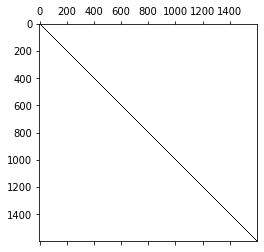

KeyboardInterrupt: 

In [36]:
uAprox = Solve_System_SSOR(f, uD, N=N)

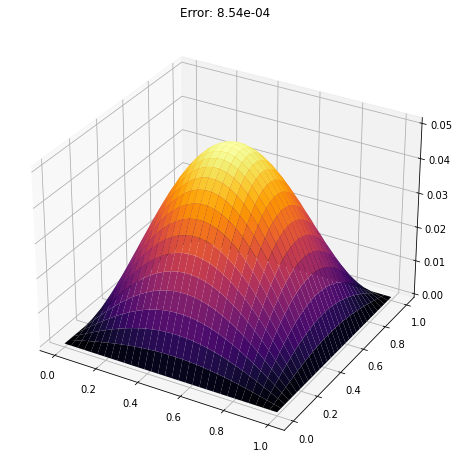

In [12]:
t = np.linspace(0, 1, num=N+2)
X, Y = np.meshgrid(t, t)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y, uAprox, cmap="inferno")
ax.set_title(f"Error: {np.linalg.norm(uAprox-sol([X, Y]), ord=np.inf):.2e}")
plt.show()

### Steepest Descent:

Para matrices simétricas definidas positivas. Como la de diferencias finitas!!!!! EEEEEEEH :)


Qué se está minimizando en este proceso?

$$f(x) = \|x-x^*\|_A^2 = \langle A(x-x^*), x-x^*\rangle = \langle Ax-b, x-x^*\rangle$$

Si bien no tenemos como conocer $x^*$, podemos de todas formas usar el error como $\|Ax-b\|_2$

In [31]:
def SteepestDescent(A, b, tol=1e-8):
    """
    AKA: Descenso de gradiente.
    """
    m, n = A.shape
    x = np.ones(n, dtype=float)/np.sqrt(n)
    err = np.dot(A@x, x)
    
    error_list = []
    
    t1 = time.time()
    
    while err > tol:
        r = b - A@x
        alpha = np.dot(r, r)/np.dot(A@r, r)
        x = x + alpha*r
        err = np.linalg.norm(A@x-b)
        error_list.append(err)
    
    print(f"Se demoró {len(error_list)} iteraciones en converger.")
    t2 = time.time()
    print(f"Se demoró {t2-t1:.2f} segundos")
    return x, error_list

In [37]:
f = lambda x: np.sin(np.pi*x[0])*np.sin(np.pi*x[1])
uD = lambda x: 0
sol = lambda x:(1/(2*np.pi**2))*np.sin(np.pi*x[0])*np.sin(np.pi*x[1])
N = 40
uAprox = np.zeros((N+2)*(N+2), dtype=float)

In [38]:
A, b, FreeNodes = FD2D_System(f, uD, N=N)

uAprox[FreeNodes], err_list = SteepestDescent(A, b)
print(f"Steepest Descent demora {len(err_list)} iteraciones")

uAprox = Fill_Boundary_Cond(uAprox, uD, FreeNodes, N=N)

Se demoró 4318 iteraciones en converger.
Se demoró 13.34 segundos
Steepest Descent demora 4318 iteraciones


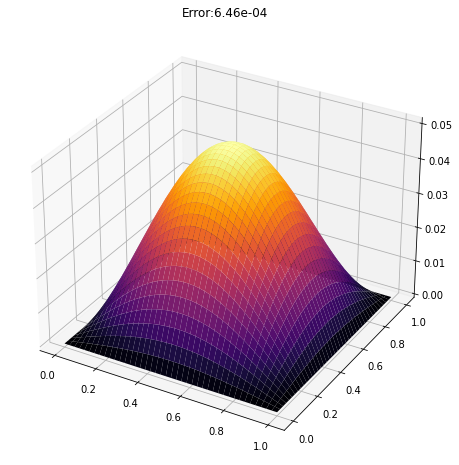

In [39]:
t = np.linspace(0, 1, num=N+2)
X, Y = np.meshgrid(t, t)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y, uAprox, cmap="inferno")
ax.set_title(f"Error:{np.linalg.norm(uAprox-sol([X, Y]), ord=np.inf):.2e}")
plt.show()